### Delft3D-FM particle tracking with dorado

This Python notebook uses the $\href{https://github.com/passaH2O/dorado}{\textbf{dorado}}$ library by to generate a particle tracking experiment for a Delft3D-FM unsteady simulation. This workflow combines the scripts $\href{https://github.com/passaH2O/dorado/blob/master/examples/unstructured_grid_anuga.ipynb}{\texttt{unstructured\_grid\_anuga.ipynb}}$ by Kyle Wright and Jay Jariharan (July, 2020) and $\href{https://github.com/passaH2O/dorado/blob/master/examples/unstructured_grid_Delft3dFM.ipynb}{\texttt{unstructured\_grid\_Delft3dFM.ipynb}}$ by Caitlin R. R. Turner (July, 2025).

$\textbf{NOTES}$:
- The script asks to define a time period (consistent with the simulation) and a portion of the domain to reduce computational time.
- The script uses the Lake Seminole Delft3D-FM model and focuses on the Chattahoochee arm of the lake. 
- The script opens a window and asks to select the simulation folder. Note that it assumes a $\texttt{dimr}$ configuration and it looks for a $\texttt{dflowfm}$ folder and a $\texttt{output}$ subfolder containing the netcdf file(s).
- The script requires the $\href{https://github.com/Deltares/dfm_tools}{\texttt{dfm\_tools}}$ package by Deltares to easily load simulation outputs. 
- The particles are injected one time at the top of the delta.

In [1]:
# --- General libraries ---
import os
import glob
import pandas as pd
import numpy as np
import datetime as dt
import json
from tqdm import tqdm

# --- Libraries for interactive folder/file selection ---
import tkinter as tk
from tkinter import filedialog

# -- Tools to process Delft3D-FM output ---
import dfm_tools as dfmt
import xarray as xr

# --- Dorado particle tracking ---
import dorado
import dorado.routines as routines
from dorado.routines import draw_travel_path
import dorado.particle_track as pt

# --- Plotting ---
import matplotlib
matplotlib.rcParams['font.family']           = 'Arial'
matplotlib.rcParams['axes.titlesize']        = 13  # Figure title size
matplotlib.rcParams['axes.labelsize']        = 12  # Axis label size
matplotlib.rcParams['xtick.labelsize']       = 12  # X tick labels size
matplotlib.rcParams['ytick.labelsize']       = 12  # Y tick labels size
matplotlib.rcParams['legend.title_fontsize'] = 12  # Legend title size
matplotlib.rcParams['legend.fontsize']       = 11  # Legend label size

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.patheffects as path_effects
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

C:\Users\cortel\AppData\Local\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\cortel\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\cortel\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# --- Time period to consider ---
tin  = '2023-10-08 00:00:00'
tend = '2023-10-22 00:00:00'

# --- Select domain ---
lon_min = 697000
lon_max = 710500
lat_min = 3397915
lat_max = 3411000

### Load and store simulation results

Select the simulation folder. Once loaded the results are sliced within the time and space window. Then, longitude, latitude, bed level, time, water depth, water level, flow velocity x-component and flow velocity y-component are stored into a dictionary. Finally, the script finds and counts the number of NaN values for each variable. The following cell allows to save the dictionary on a text file (not necessary).

In [4]:
# --- Select the simulation folder and extract the necessary variables ---
root = tk.Tk()
root.withdraw() # Hide the main Tkinter window

# --- Ask the user to select a file ---
folder_path  = filedialog.askdirectory(title="Select simulation directory")

if folder_path:
    print("---> Selected folder:", folder_path, "\n")
          
    # --- Create a folder where we save the figures and other post-processing stuff ---
    #output_folder = os.path.basename(folder_path)
    output_folder = "test_multiple_points_3_points"
    os.makedirs(output_folder, exist_ok = True)
else:
    print("!!! No folder selected !!!")

# --- Read the FlowFM_map.nc file ---
map_netcdf = os.path.join(folder_path, "dflowfm", "output", 'FlowFM_*_map.nc')
print("---> Reading:", map_netcdf, "\n")

# --- Open the map netcdf ---
map_xr = dfmt.open_partitioned_dataset(map_netcdf)

# --- Slice data ---
# Time
map_xr = map_xr.sel(time=slice(tin, tend))

# Space
map_xr = map_xr.ugrid.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))

# --- Extract the variables ---
x     = map_xr.mesh2d_face_x.values.astype(np.float32).tolist()      # longitude
y     = map_xr.mesh2d_face_y.values.astype(np.float32).tolist()      # latitude
elev  = map_xr.mesh2d_flowelem_bl.values.astype(np.float32).tolist() # bed level
time  = map_xr.time.values.astype(np.float32).tolist()               # time
stage = map_xr.mesh2d_s1.values.astype(np.float32).tolist()          # water level
depth = map_xr.mesh2d_waterdepth.values.astype(np.float32).tolist()  # water depth
u     = map_xr.mesh2d_ucx.values.astype(np.float32).tolist()         # velocity x-component
v     = map_xr.mesh2d_ucy.values.astype(np.float32).tolist()         # velocity y-component

# --- Store the necessary variables into a dictonary ---
unstructured = dict()
unstructured['x']         = x     
unstructured['y']         = y    
unstructured['time']      = time
unstructured['elevation'] = elev 
unstructured['stage']     = stage
unstructured['depth']     = depth
unstructured['u']         = u     
unstructured['v']         = v 

# --- Run a check for NaNs ---
print("\n---> Field summary (length, shape, NaNs)")
for key, arr in unstructured.items():
    arr_np = np.array(arr, dtype=np.float32)
    nan_count = np.isnan(arr_np).sum()
    total = arr_np.size
    pct = (nan_count / total * 100) if total > 0 else 0
    print(f"{key:12s} | shape: {arr_np.shape!s:20s} | length: {total:8d} | NaNs: {nan_count:8d} ({pct:6.2f}%)")

---> Selected folder: C:/Users/cortel/Desktop/SSCweir 

---> Reading: C:/Users/cortel/Desktop/SSCweir\dflowfm\output\FlowFM_*_map.nc 

>> xu.open_dataset() with 8 partition(s): 1 2 3 4 5 6 7 8 : 3.23 sec
>> xu.merge_partitions() with 8 partition(s): 0.89 sec
>> dfmt.open_partitioned_dataset() total: 4.12 sec

---> Field summary (length, shape, NaNs)
x            | shape: (57509,)             | length:    57509 | NaNs:        0 (  0.00%)
y            | shape: (57509,)             | length:    57509 | NaNs:        0 (  0.00%)
time         | shape: (337,)               | length:      337 | NaNs:        0 (  0.00%)
elevation    | shape: (57509,)             | length:    57509 | NaNs:        0 (  0.00%)
stage        | shape: (337, 57509)         | length: 19380533 | NaNs:  7458470 ( 38.48%)
depth        | shape: (337, 57509)         | length: 19380533 | NaNs:        0 (  0.00%)
u            | shape: (337, 57509)         | length: 19380533 | NaNs:        0 (  0.00%)
v            | shape: (33

In [ ]:
# --- Save dictionary into a json (text) file ---
# !!! Run this cell if you really need to save the variables
# !!! WARNING: it can take a bit and the JSON file can be heavy (> 1GB)
print(f'---> Saving {os.path.join(output_folder, 'unstructured_model.txt')}')
with open(os.path.join(output_folder, 'unstructured_model.txt'), 'w') as f:
    json.dump(unstructured, f, indent=2)
print('---> Done!')

### Convert to structured grid

The script loads the latitude and longitude of model's boundary. The coordinates are stored in a separate $\texttt{model.csv}$ file. Then, the function $\texttt{unstruct2grid}$ is used to make the conversion that uses the IDW interpolation. Finally, the injection point is defined and a simple map is saved showing the structured bed level with the injection point.

---> Particles will be injected in [(2, 11), (193, 443), (110, 409)]


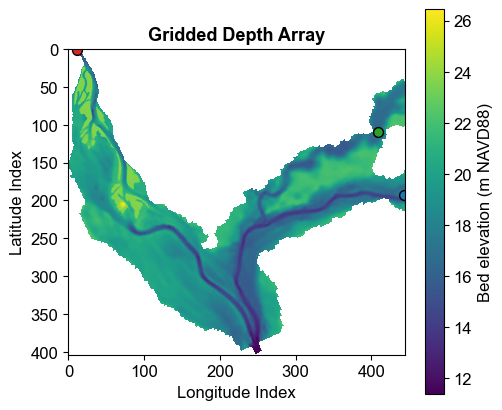

In [7]:
# --- Extract the model boundary ---
boundaries = pd.read_csv("model_boundary/model.csv")

# --- Combine (x,y) into list of tuples ---
coordinates = [(unstructured['x'][i], unstructured['y'][i]) for i in list(range(len(unstructured['x'])))]

# --- Use IDW interpolation to interpolate unstructured data into a uniform grid ---
# Use the elevation (i.e. topography)
res = 30 # resolution of uniform grid
knn = 5  # k nearest neighbours to include in the interpolation (higher values = smoother interp)
myInterp, elevation = pt.unstruct2grid(coordinates, unstructured['elevation'], res, knn, boundary=boundaries, crop=True)

# --- Define a release location ---
seedlocs = [(697525, 3410992), # upstream Chattahoochee
          (710493, 3405261), # downstream Flint
           (709459, 3407761)]    # downstream Spring Creek

# --- Define the colors for each release point ---
colors = ['tab:red', 'tab:blue', 'tab:green']

# Convert to grid indices
seedinds = pt.coord2ind(seedlocs, (min(unstructured['x']), min(unstructured['y'])), np.shape(elevation), res)
print(f"---> Particles will be injected in {seedinds}")

# --- Simple plot of uniform grid and injection point ---
fig0, ax0 = plt.subplots(figsize=(5,5))
for i in range(len(seedinds)):
    s = seedinds[i]
    color = colors[i] # Get the corresponding color
    ax0.scatter(s[1], s[0], s=50, c=color, edgecolors='k') # Use the specific color
im = ax0.imshow(elevation, cmap='viridis')
ax0.set_title('Gridded Depth Array', fontweight = "bold")
ax0.set_xlabel('Longitude Index')
ax0.set_ylabel('Latitude Index')

cbar = fig0.colorbar(im, fraction=0.08)
cbar.ax.set_ylabel('Bed elevation (m NAVD88)')

fig0.savefig(os.path.join(output_folder, "gridded_depth.png"), dpi=500, bbox_inches="tight")

plt.show()

### Run particle tracking algorithm

This script runs the particle tracking algorithm and saves a figure for each snapshot. The trajectories are also saved in a text file. The initial position of the particle is initialized with the variables of the first timestep. Then, the movement of each particle is tracked for the subsequent steps. The $\texttt{Particle}$ and $\texttt{generate\_particles}$ functions are used to initialize the particle object using the defined parameters and position all particles in the injection point. The time-dependent variables are updated at each timestep. 

In [8]:
# --- Define particle tracking parameters ---
n_particles = 200  # per injection point
timestep    = 3600 # seconds (this is the output resolution) 
n_timesteps = (len(unstructured['time'])-1) # number of timesteps

# --- Create the parameters object and then assign the values ---
params            = pt.modelParams()
params.topography = unstructured['elevation']
params.theta      = 1.0
params.gamma      = 0.05
params.diff_coeff = 0.2
params.dx         = 30 
params.dry_depth  = 0.01
params.verbose    = False

# --- Create target times (for Dorado’s internal time counter) ---
target_times = np.arange(0, timestep * (n_timesteps + 1), timestep).astype(int)

# --- Initialize depth and velocities with the first timestep ---
# Note that these changes every timestep
params.stage = myInterp(unstructured['stage'][0])
params.depth = myInterp(unstructured['depth'][0])
params.u     = myInterp(unstructured['u'][0])
params.v     = myInterp(unstructured['v'][0])

# --- Initialize particles object ---
particles = pt.Particles(params)

# --- Create one Particles object per seed point ---
all_particles = []
for i, seed in enumerate(seedinds):
    x0, y0 = seed
    seed_xloc = [x0 - 1, x0 + 1]
    seed_yloc = [y0 - 1, y0 + 1]

    p = pt.Particles(params)
    p.generate_particles(n_particles, seed_xloc, seed_yloc, seed_time=0, method='exact')
    all_particles.append(p)
    print(f"---> Injected {n_particles} particles at seed #{i+1} (indices {seed})")

snapshots_dir = os.path.join(output_folder, "snapshots")
os.makedirs(snapshots_dir, exist_ok=True)

# --- Run particle tracking ---
#colors          = ['tab:red', 'tab:green'] # add more color for more seeding points
walk_data_all   = [{"xinds": [], "yinds": [], "travel_times": []} for _ in seedinds]
prev_counts_all = [None] * len(seedinds)

# Unsteady flow (i.e. time-variable) and single particle injection in multiple points
for t_idx in range(1, n_timesteps):
    
    # --- Rasterize the time-dependent variables and update params ---
    params.stage = myInterp(unstructured['stage'][t_idx])
    params.depth = myInterp(unstructured['depth'][t_idx])
    params.u     = myInterp(unstructured['u'][t_idx])
    params.v     = myInterp(unstructured['v'][t_idx])

    # --- Initialize figure for this timestep ---
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    im = ax1.imshow(params.depth, cmap='Blues_r', origin='lower', vmin=0, vmax=10)

    # --- Run iteration for each injection ---
    for j, (p, color) in enumerate(zip(all_particles, colors)):
        p.params = params
        walk_data = p.run_iteration(target_times[t_idx])
        
        # --- Update walk_data_all for bookkeeping ---
        wd_seed = walk_data_all[j]
        for key in ["xinds", "yinds", "travel_times"]:
            wd_seed[key].extend(walk_data[key])

        # --- Extract last particle positions ---
        x_t = np.array([traj[-1] for traj in walk_data["xinds"] if len(traj) > 0])
        y_t = np.array([traj[-1] for traj in walk_data["yinds"] if len(traj) > 0])

        # --- Plot each injection in its own color ---
        ax1.scatter(y_t, x_t, s=20, c=[color], alpha=0.7)#, label=f"Seed {j+1}")
    
    # --- Add last details to the snapshot and save ---
    ax1.set_title(f"Timestep {t_idx}", fontweight="bold")
    ax1.set_xlabel('Longitude Index')
    ax1.set_ylabel('Latitude Index')
    ax1.invert_yaxis()

    cbar = fig1.colorbar(im, fraction=0.1, extend='max')
    cbar.ax.set_ylabel('Water depth (m)')
    ax1.text(0.02, 0.02, fr'$\theta = {params.theta}$', transform=ax1.transAxes, fontsize=12, va='bottom')

    fig1.savefig(os.path.join(snapshots_dir, f"particles_depth_t{t_idx:03d}.png"), dpi=300, bbox_inches="tight")
    plt.close()

# --- Prepare flat combined dictionary for Dorado output ---
dorado_data = {
    "xinds": [],
    "yinds": [],
    "travel_times": []}

for wd in walk_data_all:
    dorado_data["xinds"].extend(wd["xinds"])
    dorado_data["yinds"].extend(wd["yinds"])
    dorado_data["travel_times"].extend(wd["travel_times"])

# --- Prepare separate dictionary by seed ---
dorado_data_by_seed = {
    f"seed_{i}": walk_data_all[i]
    for i in range(len(seedinds))}    

---> Injected 200 particles at seed #1 (indices (2, 11))
---> Injected 200 particles at seed #2 (indices (193, 443))
---> Injected 200 particles at seed #3 (indices (110, 409))


### Save trajectories
The following cell saves the trajectories expressed as x and y indices. A txt and csv files are created. WARNING! This cell can take some time to completely run. The size of the output files can be large (>1 GB). If you don't need to save each trajectory, just skip this cell.

In [54]:
# --- Save as text file ---
with open(os.path.join(output_folder, "walk_data_combined.txt"), "w") as f:
    json.dump(dorado_data, f, indent=2)

with open(os.path.join(output_folder, "walk_data_by_seed.txt"), "w") as f:
    json.dump(dorado_data_by_seed, f, indent=2)
    
# --- Save as csv file ---
records = []

for seed_id, wd in dorado_data_by_seed.items():
    for pid, (x_list, y_list, t_list) in enumerate(
        zip(wd['xinds'], wd['yinds'], wd['travel_times'])
    ):
        for x, y, t in zip(x_list, y_list, t_list):
            records.append((seed_id, pid, x, y, t))

df = pd.DataFrame(records, columns=["injection_point_id", "particle_id", "x_index", "y_index", "time"])
df.to_csv(os.path.join(output_folder, "walk_data_by_seed.csv"), index=False)

### Generate animation
Create an animation using the snapshots. The script simply stiches together the frames and creates the animation.

In [9]:
# --- Get all frames ---
frame_files = sorted(glob.glob(os.path.join(snapshots_dir, "particles_depth_t*.png")))

# --- Initialize the figure ---
fig2, ax2 = plt.subplots(figsize=(5, 5))
im = ax2.imshow(mpimg.imread(frame_files[0]))
ax2.axis('off')

# --- Update function for each frame ---
def update(frame):
    img = mpimg.imread(frame)
    im.set_array(img)
    return [im]

# --- Create the animation ---
ani = animation.FuncAnimation(
    fig2, update, frames=frame_files, interval=200, blit=True, repeat=False
)

# --- Save animation ---
output_video = os.path.join(output_folder, "particle_tracking.gif")
ani.save(output_video, writer='pillow', fps=5)

plt.close(fig2)

### Generate particle travel paths
This script is basically the function $\texttt{routines.draw\_travel\_path}$ with some small adjustments to make the plot consistent with the others

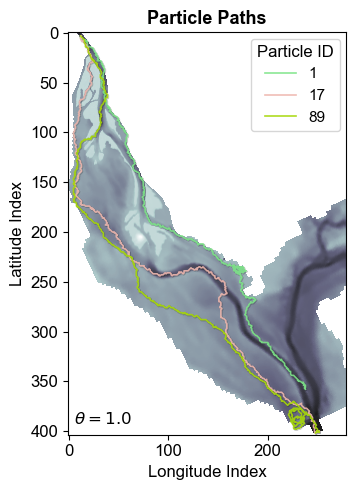

In [62]:
# --- Plot settings ---
particles_to_follow = [1, 17, 89] # particle IDs
interval            = 1           # Nmber of timestep to consider (1 = all)
plot_legend         = True        # Add legend (Yes/No)

if(particles_to_follow == 'all'):
    Np_tracer           = len(walk_data['xinds'])
    particles_to_follow = list(range(Np_tracer))

# --- Make the plot ---
fig3, ax3 = plt.subplots(figsize=(5, 5))
im = ax3.imshow(elevation, cmap='bone', alpha=0.9)
ax3.set_title('Particle Paths', fontweight = "bold")
ax3.set_xlabel('Longitude Index')
ax3.set_ylabel('Latitude Index')

paths  = []  # Place to store particle paths
colors = []  # Place to store colors
for i in particles_to_follow:
    # Set color for this particle
    c = np.random.rand(3,)
    colors.append([c[0], c[1], c[2], 0.9])

    x       = walk_data['xinds'][i][0::interval]
    y       = walk_data['yinds'][i][0::interval]
    lineseg = list(zip(y, x))
    paths.append(lineseg)

# Add new line collection to our figure, apply a background shadow
lc = LineCollection(paths, colors=colors,linewidths=1.2, capstyle='round',
                    path_effects=[path_effects.SimpleLineShadow(offset=(0.5, -0.5), alpha=0.2, linewidth=1.6),
                                  path_effects.Normal()])
ax3.add_collection(lc)

# Add the value of theta
ax3.text(0.02, 0.02, r'$\theta = {theta}$'.format(theta=params.theta), transform=ax3.transAxes, fontsize=12, verticalalignment='bottom')

if plot_legend:
    custom_lines = [Line2D([0], [0], color=c, lw=1.2) for c in colors]
    ax3.legend(custom_lines, [str(i) for i in particles_to_follow],
               loc='center left', bbox_to_anchor=(0.63, 0.87), title='Particle ID')
    
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "particle_travel_path.png"), dpi=500, bbox_inches='tight')

plt.show()

### Compute nourishment area
This scripts computes the nourishment area using the $\texttt{dorado.particle\_track.nourishment\_area}$ function. Then it plots the results. The plot is essentially the $\texttt{routines.show\_nourishment\_area}$ with minor adjustments for plotting consistency.

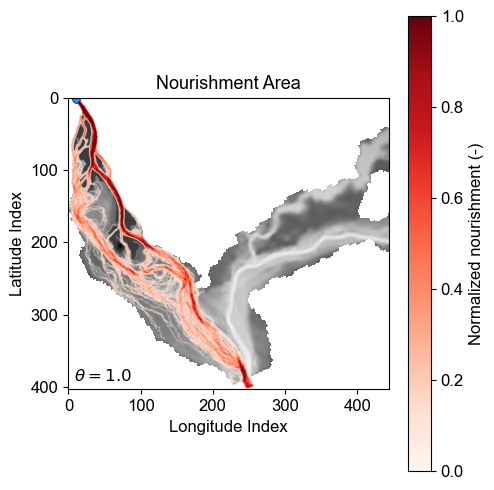

In [25]:
# --- Select injection point ---
injection_point = "seed_0"

# --- Compute history of particle travel locations ---
# First, isolate the trajectory of particle from the specified injection point
walk_data_selected_seed = dorado_data_by_seed[injection_point]
visit_freq = pt.nourishment_area(walk_data_selected_seed, np.shape(elevation))

# --- Parameters ---
cmap       = 'Reds'       # colormap
sigma      = 0.7          # degree of spatial smoothing used in pt.nourishment_area 0.7=default
min_alpha  = 0            # min value of heatmap
show_seed  = True         # shows a marker indicating the (first) seed location
seed_color = 'dodgerblue' # seed location color

# --- Plot heatmap with alpha based on visit_freq ---
if sigma >= 0.125:  # This is just a visual trial-and-error thing
    amax = np.nanpercentile(visit_freq, 60)
else:
    amax = np.nanpercentile(visit_freq, 30)

alphas = Normalize(0, amax, clip=True)(visit_freq)  # Normalize alphas
alphas = np.clip(alphas, min_alpha, 1)
colors = Normalize(np.nanmin(visit_freq), 1)(visit_freq)  # Normalize color
cmap = plt.get_cmap(cmap)
colors = cmap(colors)
colors[..., -1] = alphas

fig4, ax4 = plt.subplots(figsize=(5,5))
im = ax4.imshow(elevation, cmap='Greys')#, vmax=np.max(elevation))
nr = ax4.imshow(colors)
ax4.set_title('Nourishment Area')
ax4.set_xlabel('Longitude Index')
ax4.set_ylabel('Latitude Index')

# Colorbar
nr.set_cmap(cmap)
cbar = fig4.colorbar(nr, fraction=0.1)
cbar.ax.set_ylabel('Normalized nourishment (-)')

# Add the value of theta
ax4.text(0.02, 0.02, r'$\theta = {theta}$'.format(theta=params.theta), transform=ax4.transAxes, fontsize=12, verticalalignment='bottom')

# Add injection point
ax4.scatter(walk_data_selected_seed['yinds'][0][0], walk_data_selected_seed['xinds'][0][0], c=seed_color, edgecolors='black', s=30, linewidths=0.5)

plt.tight_layout()

plt.savefig(os.path.join(output_folder, "nourishment_area.png"), dpi=500, bbox_inches='tight')

plt.show()

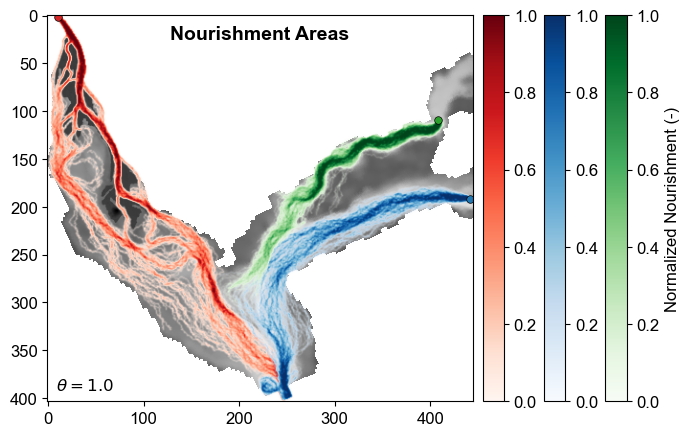

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Define the injection points and their visualization settings ---
injection_points = ["seed_0", "seed_1", "seed_2"]     # Define the injection points (this is how they are saved)
cmaps            = ['Reds', 'Blues', 'Greens']        # Colormaps for each seed
seed_colors      = ['tab:red', 'tab:blue', 'tab:green'] # Marker colors for each seed

# --- Common Parameters ---
sigma     = 0.7          # degree of spatial smoothing used in pt.nourishment_area 0.7=default
min_alpha = 0            # min value of heatmap
show_seed = True         # shows a marker indicating the (first) seed location

fig4, ax4 = plt.subplots(figsize=(7,5))

divider = make_axes_locatable(ax4)

im = ax4.imshow(elevation, cmap='Greys')
#ax4.set_title('Nourishment Area')
#ax4.set_xlabel('Longitude Index')
#ax4.set_ylabel('Latitude Index')

# List to hold the image objects for the colorbars
nr_images = []

# --- Loop through each seed to calculate and plot its nourishment area
for i, injection_point in enumerate(injection_points):
    cmap_name          = cmaps[i]
    current_seed_color = seed_colors[i]

    # Compute history of particle travel locations
    walk_data_selected_seed = dorado_data_by_seed[injection_point]
    visit_freq              = pt.nourishment_area(walk_data_selected_seed, np.shape(elevation))

    # --- Plot heatmap with alpha based on visit_freq ---
    if sigma >= 0.125:
        amax = np.nanpercentile(visit_freq, 60)
    else:
        amax = np.nanpercentile(visit_freq, 30)

    alphas = Normalize(0, amax, clip=True)(visit_freq)
    alphas = np.clip(alphas, min_alpha, 1)
    colors_norm = Normalize(np.nanmin(visit_freq), 1)(visit_freq) 
    cmap        = plt.get_cmap(cmap_name)
    colors      = cmap(colors_norm)
    colors[..., -1] = alphas

    # Plot the nourishment area for the current seed as a layer
    nr = ax4.imshow(colors, label=injection_point)
    nr.set_cmap(cmap) # Set cmap for the colorbar later
    nr_images.append(nr) # Store the image object

    # Add injection point
    # Note: Use the corresponding index [0] to get the starting location
    ax4.scatter(walk_data_selected_seed['yinds'][0][0], walk_data_selected_seed['xinds'][0][0], 
                c=current_seed_color, edgecolors='black', s=30, linewidths=0.5, 
                label=f'Injection Point ({injection_point})')

    # --- Create Separate Colorbar for the Current Seed ---
    if i == 0:
        # Create a new axis for the first colorbar (Red)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig4.colorbar(nr, cax=cax)
        #cbar.ax.set_ylabel(f'Normalized Nourishment - {injection_point} (Red)')
    elif i == 1:
        # Create a new axis for the second colorbar (Blue)
        # Use a slightly larger pad to stack it below the first colorbar's axis
        cax2 = divider.append_axes("right", size="5%", pad=0.4) 
        cbar2 = fig4.colorbar(nr, cax=cax2)
        #cbar2.ax.set_ylabel(f'Normalized Nourishment (-)')
    elif i == 2:
        # Create a new axis for the third colorbar (Green)
        # Use a slightly larger pad to stack it below the first colorbar's axis
        cax3 = divider.append_axes("right", size="5%", pad=0.4) 
        cbar3 = fig4.colorbar(nr, cax=cax3)
        cbar3.ax.set_ylabel(f'Normalized Nourishment (-)')

# Add the value of theta (assuming 'params.theta' is still defined)
ax4.text(0.02, 0.02, r'$\theta = {theta}$'.format(theta=params.theta), transform=ax4.transAxes, fontsize=12, verticalalignment='bottom')
ax4.text(0.5, 0.95, 'Nourishment Areas'.format(theta=params.theta), transform=ax4.transAxes, fontsize=14, fontweight='bold', horizontalalignment='center',
     verticalalignment='center')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "two_nourishment_areas.png"), dpi=500, bbox_inches='tight')
plt.show()